# Baseline Models for AI-Generated Code Detection

**Task**: Classify code as Human (0), AI-generated (1), Hybrid (2), or Adversarial (3)

**Metric**: Macro F1-score

**Approach**: Classical ML with TF-IDF features

In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from xgboost import XGBClassifier

## 1. Load Data

In [27]:
# Load datasets
train_df = pd.read_parquet('Task_C/train.parquet')[:100000]
val_df = pd.read_parquet('Task_C/validation.parquet')[:100000]
test_df = pd.read_parquet('Task_C/test.parquet')
test_sample_df = pd.read_parquet('Task_C/test_sample.parquet')

print(f"Train: {len(train_df):,} samples")
print(f"Validation: {len(val_df):,} samples")
print(f"Test: {len(test_df):,} samples")
print(f"Test Sample (with labels): {len(test_sample_df):,} samples")

Train: 100,000 samples
Validation: 100,000 samples
Test: 1,000 samples
Test Sample (with labels): 1,000 samples


In [28]:
# Check class distribution
print("\nTraining set class distribution:")
print(train_df['label'].value_counts().sort_index())
print("\nPercentages:")
print(train_df['label'].value_counts(normalize=True).sort_index() * 100)


Training set class distribution:
label
0    53626
1    23658
2     9502
3    13214
Name: count, dtype: int64

Percentages:
label
0    53.626
1    23.658
2     9.502
3    13.214
Name: proportion, dtype: float64


## 2. Prepare Data

In [29]:
# Extract features and labels
X_train = train_df['code'].values
y_train = train_df['label'].values

X_val = val_df['code'].values
y_val = val_df['label'].values

X_test = test_sample_df['code'].values
y_test = test_sample_df['label'].values

print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")
print(f"Test samples: {len(X_test):,}")

Training samples: 100,000
Validation samples: 100,000
Test samples: 1,000


## 3. Feature Extraction - TF-IDF

We'll try different n-gram configurations:
- Word n-grams (1-3)
- Character n-grams (3-5)
- Combined

In [30]:
# Experiment 1: Word n-grams (1-3)
print("Creating TF-IDF features (word 1-3 grams)...")
tfidf_word = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 3),
    max_features=10000,
    min_df=2,
    sublinear_tf=True
)

start = time()
X_train_word = tfidf_word.fit_transform(X_train)
X_val_word = tfidf_word.transform(X_val)
X_test_word = tfidf_word.transform(X_test)
print(f"Done in {time() - start:.2f}s")
print(f"Feature shape: {X_train_word.shape}")

Creating TF-IDF features (word 1-3 grams)...
Done in 53.46s
Feature shape: (100000, 10000)


In [31]:
# Experiment 2: Character n-grams (3-5)
print("\nCreating TF-IDF features (char 3-5 grams)...")
tfidf_char = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    max_features=10000,
    min_df=2,
    sublinear_tf=True
)

start = time()
X_train_char = tfidf_char.fit_transform(X_train)
X_val_char = tfidf_char.transform(X_val)
X_test_char = tfidf_char.transform(X_test)
print(f"Done in {time() - start:.2f}s")
print(f"Feature shape: {X_train_char.shape}")


Creating TF-IDF features (char 3-5 grams)...
Done in 157.67s
Feature shape: (100000, 10000)


## 4. Training & Evaluation Functions

In [34]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    """
    Train and evaluate a model on train, validation, and test sets.
    """
    print(f"\n{'='*60}")
    print(f"Model: {model_name}")
    print(f"{'='*60}")
    
    # Train
    print("Training...")
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    print(f"Training time: {train_time:.2f}s")
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Evaluate
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    
    print(f"\nMacro F1 Scores:")
    print(f"  Train: {train_f1:.4f}")
    print(f"  Val:   {val_f1:.4f}")
    print(f"  Test:  {test_f1:.4f}")
    
    # Detailed validation report
    print(f"\nValidation Set Classification Report:")
    print(classification_report(y_val, y_val_pred, 
                                target_names=['Human (0)', 'AI (1)', 'Hybrid (2)', 'Adversarial (3)']))
    
    # Test set report
    print(f"\nTest Set Classification Report:")
    print(classification_report(y_test, y_test_pred, 
                                target_names=['Human (0)', 'AI (1)', 'Hybrid (2)', 'Adversarial (3)']))
    
    return {
        'model_name': model_name,
        'train_f1': train_f1,
        'val_f1': val_f1,
        'test_f1': test_f1,
        'train_time': train_time,
        'model': model,
        'y_test_pred': y_test_pred
    }

## 5. Experiment 1: Word N-grams + Models

In [35]:
results = []

In [36]:
# Model 1: Logistic Regression with word n-grams
lr_word = LogisticRegression(
    max_iter=500,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)

result = evaluate_model(lr_word, X_train_word, y_train, X_val_word, y_val, 
                       X_test_word, y_test, "Logistic Regression (Word 1-3 grams)")
results.append(result)


Model: Logistic Regression (Word 1-3 grams)
Training...


Training time: 8.70s

Macro F1 Scores:
  Train: 0.6626
  Val:   0.5726
  Test:  0.5297

Validation Set Classification Report:
                 precision    recall  f1-score   support

      Human (0)       0.87      0.77      0.82     54096
         AI (1)       0.67      0.60      0.64     23285
     Hybrid (2)       0.30      0.45      0.36      9506
Adversarial (3)       0.42      0.54      0.47     13113

       accuracy                           0.67    100000
      macro avg       0.57      0.59      0.57    100000
   weighted avg       0.71      0.67      0.69    100000


Test Set Classification Report:
                 precision    recall  f1-score   support

      Human (0)       0.86      0.75      0.80       554
         AI (1)       0.62      0.58      0.60       228
     Hybrid (2)       0.23      0.35      0.27        84
Adversarial (3)       0.39      0.51      0.44       134

       accuracy                           0.65      1000
      macro avg       0.52      0.55  

In [37]:
# Model 2: Random Forest with word n-grams
rf_word = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    max_depth=20
)

result = evaluate_model(rf_word, X_train_word, y_train, X_val_word, y_val, 
                       X_test_word, y_test, "Random Forest (Word 1-3 grams)")
results.append(result)


Model: Random Forest (Word 1-3 grams)
Training...
Training time: 1.72s

Macro F1 Scores:
  Train: 0.6596
  Val:   0.5402
  Test:  0.5245

Validation Set Classification Report:
                 precision    recall  f1-score   support

      Human (0)       0.79      0.81      0.80     54096
         AI (1)       0.71      0.48      0.58     23285
     Hybrid (2)       0.35      0.34      0.34      9506
Adversarial (3)       0.37      0.54      0.44     13113

       accuracy                           0.65    100000
      macro avg       0.55      0.54      0.54    100000
   weighted avg       0.67      0.65      0.66    100000


Test Set Classification Report:
                 precision    recall  f1-score   support

      Human (0)       0.81      0.81      0.81       554
         AI (1)       0.68      0.50      0.57       228
     Hybrid (2)       0.26      0.27      0.27        84
Adversarial (3)       0.38      0.55      0.45       134

       accuracy                           0.

In [38]:
# Model 3: XGBoost with word n-grams (if available)
# Calculate scale_pos_weight for each class
class_counts = np.bincount(y_train)
total = len(y_train)

xgb_word = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

result = evaluate_model(xgb_word, X_train_word, y_train, X_val_word, y_val, 
                        X_test_word, y_test, "XGBoost (Word 1-3 grams)")
results.append(result)


Model: XGBoost (Word 1-3 grams)
Training...
Training time: 60.65s

Macro F1 Scores:
  Train: 0.5963
  Val:   0.5462
  Test:  0.5184

Validation Set Classification Report:
                 precision    recall  f1-score   support

      Human (0)       0.75      0.97      0.84     54096
         AI (1)       0.69      0.61      0.65     23285
     Hybrid (2)       0.60      0.19      0.28      9506
Adversarial (3)       0.63      0.31      0.41     13113

       accuracy                           0.72    100000
      macro avg       0.67      0.52      0.55    100000
   weighted avg       0.70      0.72      0.69    100000


Test Set Classification Report:
                 precision    recall  f1-score   support

      Human (0)       0.77      0.96      0.86       554
         AI (1)       0.64      0.63      0.63       228
     Hybrid (2)       0.44      0.10      0.16        84
Adversarial (3)       0.64      0.32      0.43       134

       accuracy                           0.73   

## 6. Experiment 2: Character N-grams + Models

In [39]:
# Model 4: Logistic Regression with char n-grams
lr_char = LogisticRegression(
    max_iter=500,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

result = evaluate_model(lr_char, X_train_char, y_train, X_val_char, y_val, 
                       X_test_char, y_test, "Logistic Regression (Char 3-5 grams)")
results.append(result)


Model: Logistic Regression (Char 3-5 grams)
Training...
Training time: 74.58s

Macro F1 Scores:
  Train: 0.7062
  Val:   0.6541
  Test:  0.6324

Validation Set Classification Report:
                 precision    recall  f1-score   support

      Human (0)       0.90      0.81      0.86     54096
         AI (1)       0.73      0.63      0.67     23285
     Hybrid (2)       0.46      0.65      0.54      9506
Adversarial (3)       0.48      0.64      0.55     13113

       accuracy                           0.73    100000
      macro avg       0.64      0.68      0.65    100000
   weighted avg       0.76      0.73      0.74    100000


Test Set Classification Report:
                 precision    recall  f1-score   support

      Human (0)       0.90      0.81      0.85       554
         AI (1)       0.70      0.63      0.67       228
     Hybrid (2)       0.41      0.55      0.47        84
Adversarial (3)       0.47      0.65      0.54       134

       accuracy                      

In [40]:
# Model 5: XGBoost with char n-grams (if available)
xgb_char = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

result = evaluate_model(xgb_char, X_train_char, y_train, X_val_char, y_val, 
                        X_test_char, y_test, "XGBoost (Char 3-5 grams)")
results.append(result)


Model: XGBoost (Char 3-5 grams)
Training...
Training time: 138.80s

Macro F1 Scores:
  Train: 0.7416
  Val:   0.6800
  Test:  0.6566

Validation Set Classification Report:
                 precision    recall  f1-score   support

      Human (0)       0.82      0.97      0.89     54096
         AI (1)       0.75      0.67      0.71     23285
     Hybrid (2)       0.70      0.50      0.58      9506
Adversarial (3)       0.67      0.46      0.54     13113

       accuracy                           0.79    100000
      macro avg       0.74      0.65      0.68    100000
   weighted avg       0.77      0.79      0.77    100000


Test Set Classification Report:
                 precision    recall  f1-score   support

      Human (0)       0.83      0.97      0.89       554
         AI (1)       0.73      0.66      0.69       228
     Hybrid (2)       0.65      0.37      0.47        84
Adversarial (3)       0.69      0.49      0.57       134

       accuracy                           0.78  

## 7. Results Summary

In [41]:
# Create results dataframe
results_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Train F1': f"{r['train_f1']:.4f}",
    'Val F1': f"{r['val_f1']:.4f}",
    'Test F1': f"{r['test_f1']:.4f}",
    'Train Time (s)': f"{r['train_time']:.2f}"
} for r in results])

print("\n" + "="*80)
print("BASELINE RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


BASELINE RESULTS SUMMARY
                               Model Train F1 Val F1 Test F1 Train Time (s)
Logistic Regression (Word 1-3 grams)   0.6626 0.5726  0.5297           8.70
      Random Forest (Word 1-3 grams)   0.6596 0.5402  0.5245           1.72
            XGBoost (Word 1-3 grams)   0.5963 0.5462  0.5184          60.65
Logistic Regression (Char 3-5 grams)   0.7062 0.6541  0.6324          74.58
            XGBoost (Char 3-5 grams)   0.7416 0.6800  0.6566         138.80


In [42]:
# Find best model based on validation F1
best_result = max(results, key=lambda x: x['val_f1'])
print(f"\n🏆 Best Model: {best_result['model_name']}")
print(f"   Val F1: {best_result['val_f1']:.4f}")
print(f"   Test F1: {best_result['test_f1']:.4f}")


🏆 Best Model: XGBoost (Char 3-5 grams)
   Val F1: 0.6800
   Test F1: 0.6566


## 8. Confusion Matrix for Best Model

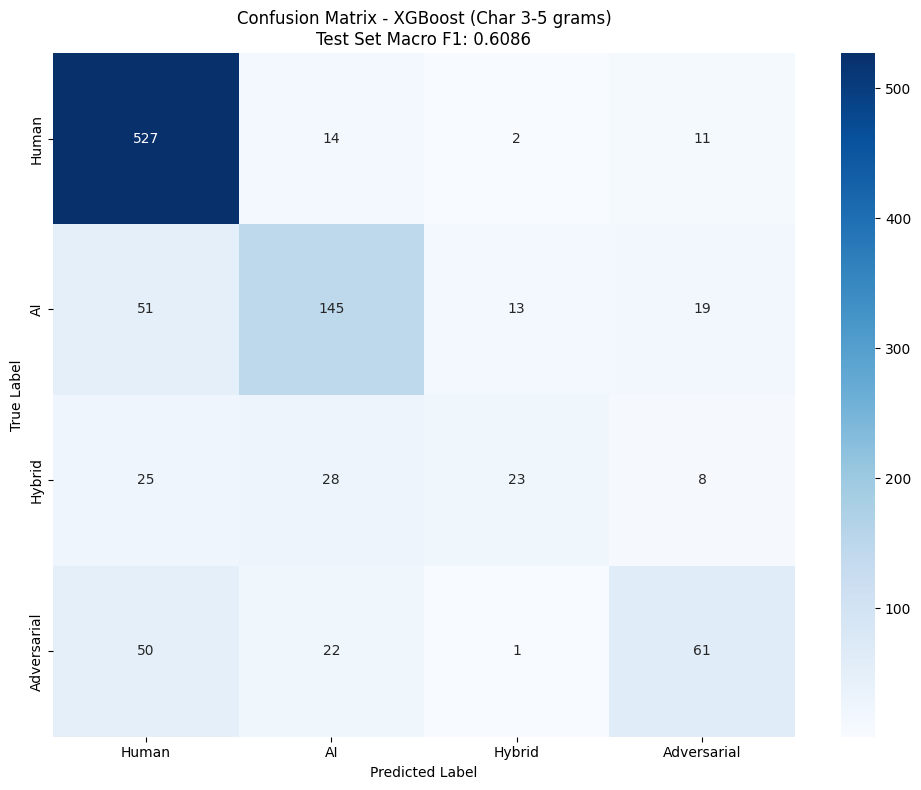

In [26]:
# Plot confusion matrix for best model on test set
cm = confusion_matrix(y_test, best_result['y_test_pred'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human', 'AI', 'Hybrid', 'Adversarial'],
            yticklabels=['Human', 'AI', 'Hybrid', 'Adversarial'])
plt.title(f'Confusion Matrix - {best_result["model_name"]}\nTest Set Macro F1: {best_result["test_f1"]:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 9. Generate Predictions for Submission

In [ ]:
# Use best model to predict on actual test set (without labels)
print(f"Generating predictions using: {best_result['model_name']}")

# Note: Need to determine which features were used by best model
# This is a placeholder - adjust based on best model
print("\nNote: Update this cell to use the correct feature transformation for the best model")
print("Current test.parquet only has 'code' column, no labels")

## 10. Next Steps

Based on baseline results:

1. **Feature Engineering**:
   - Combine word + char n-grams
   - Add code-specific features (length, complexity, etc.)
   - Try different max_features values

2. **Model Improvements**:
   - Hyperparameter tuning
   - Try ensemble methods
   - Experiment with SMOTE for minority classes

3. **Deep Learning**:
   - Try CodeBERT/GraphCodeBERT
   - Fine-tune transformer models

4. **Analysis**:
   - Analyze misclassifications
   - Feature importance analysis
   - Per-language performance